## MCMC Sampler
This notebook contains the MCMC sampler. It will sample the fiducial cosmology and the noise datavectors. Make sure to generate datavectors from chisq.ipynb first. Much of the sampling code is identitical to the code in the "LSST-Year1-tutorial" repository I forked.

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib notebook

In [29]:
### Functions
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    #plt.show()
    
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.001, 0.99]])

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [30]:
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/tension_calibration/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

In [31]:
lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

In [32]:
# Code taken from the emulator notebook
#first the fiducial cosmology

configfile = 'configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = 'output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load('model/nn_emu/model')
# ======================================================

data_model.emu = emu

In [33]:
bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

In [34]:
N_MCMC        = 50000
N_WALKERS     = 120
NDIM_SAMPLING = 29

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [35]:
#start_time = time.time()
#with Pool(10) as pool:
#    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
#    emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

In [36]:
#fig, ax = plt.subplots(5,1,figsize=(10,12.5))
#
#for i in range(5):
#    ax[i].plot(emu_sampler.chain[:,:,i].T, 'k-', lw=0.3)
#    
#plt.show()

In [37]:
N_BURN_IN = 3000
N_THIN    = 50

In [38]:
#samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

In [39]:
#plot_cosmo_contours([samples], ['Fiducial scalecut'])

In [40]:
# save fiducial
#d = '/home/grads/data/evan/tension_calibration/mc_data/fiducial'
names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
#cosmo_samples = samples[:,:5]
#s = MCSamples(samples=cosmo_samples,names = names, labels=labels)
#s.saveAsText(root=d,chain_index=None,make_dirs=True)

In [41]:
# For now I will just pick 1 data vector from each confidence interval
dv_dir = '/home/grads/data/evan/tension_calibration/dvs/'
confidence_levels = [0.6827,0.9545,0.9973,1]
dvs_67 = dv_dir+'noisy_dv_0.6827.csv'
dvs_95 = dv_dir+'noisy_dv_0.9545.csv'
dvs_99 = dv_dir+'noisy_dv_0.9973.csv'
dvs_1  = dv_dir+'noisy_dv_1.csv'

#dirs = [ dv_dir+'noisy_dv_'+str(cl)+'.csv' for cl in confidence_levels ]

dvs67 = np.loadtxt(dvs_67,delimiter=',')
dvs95 = np.loadtxt(dvs_95,delimiter=',')
dvs99 = np.loadtxt(dvs_99,delimiter=',')
    
#print(noise_samples)

In [42]:
i=0
d = '/home/grads/data/evan/tension_calibration/mc_data/noise'
names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']

for data_vector in dvs67:
    print('data vector {}/{}'.format(i,len(dvs67)))
    i += 1
    data_model.dv_obs = data_vector
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

    # write chains to files
    samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    cosmo_samples = _s[:,:5]
    s = MCSamples(samples=cosmo_samples,names = names, labels=labels)
    s.saveAsText(root=d+'_'+str(confidence_levels[0]+'_'+str(i)),chain_index=None,make_dirs=True)

i=0
for data_vector in dvs95:
    print('data vector {}/{}'.format(i,len(dvs95)))
    i += 1
    data_model.dv_obs = data_vector
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

    # write chains to files
    samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    cosmo_samples = _s[:,:5]
    s = MCSamples(samples=cosmo_samples,names = names, labels=labels)
    s.saveAsText(root=d+'_'+str(confidence_levels[1]+'_'+str(i)),chain_index=None,make_dirs=True)

i=0
for data_vector in dvs99:
    print('data vector {}/{}'.format(i,len(dvs99)))
    i += 1
    data_model.dv_obs = data_vector
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

    # write chains to files
    samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    cosmo_samples = _s[:,:5]
    s = MCSamples(samples=cosmo_samples,names = names, labels=labels)
    s.saveAsText(root=d+'_'+str(confidence_levels[2]+'_'+str(i)),chain_index=None,make_dirs=True)

data vector 0/40


  0%|▏                                                                                    | 102/50000 [00:07<1:00:32, 13.74it/s]

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:





emcee: Exception while calling your likelihood function:  params:
emcee: Exception while calling your likelihood function:  params:  params:  params:  params:
  params:  params: 
 
   params:     params:   params: [ 3.05459973e+00  9.71525102e-01  6.89301267e+01  2.12190451e-02
  1.18912141e-01 -2.59348087e-03  6.43908539e-03  5.39271891e-03
 -1.75425041e-03 -1.10653235e-03  5.42490197e-01 -3.78555471e-01
 -6.46856539e-03 -1.41608144e-03 -7.33465098e-03  1.45466282e-03
  3.94852743e-03  1.21091712e+00  1.39787793e+00  1.46025228e+00
  1.538

Traceback (most recent call last):


Traceback (most recent call last):


  exception:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


Traceback (most recent call last):
  File "/tmp/ipykernel_3103537/526516849.py", line 102, in lnprob
    return lnprior(theta) + ln_lkl(theta)
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_3103537/526516849.py", line 97, in ln_lkl
    model_datavector = get_data_vector_emu(theta)
  File "/tmp/ipykernel_3103537/526516849.py", line 102, in lnprob
    return lnprior(theta) + ln_lkl(theta)
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args,

  File "/tmp/ipykernel_3103537/526516849.py", line 97, in ln_lkl
    model_datavector = get_data_vector_emu(theta)
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/data_model/lsst_3x2.py", line 35, in compute_datavector
    datavector = self.emu.predict(theta)[0]
  File "/tmp/ipykernel_3103537/526516849.py", line 112, in get_data_vector_emu
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
  File "/tmp/ipykernel_3103537/526516849.py", line 112, in get_data_vector_emu
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/data_model/lsst_3x2.py", line 35, in compute_datavector
    datavector = self.emu.predict(theta)[0]
  File "/tmp/ipykernel_3103537/526516849.py", line 97, in ln_lkl
    model_datavector = get_data_vector_emu(theta)


  args:

  File "/tmp/ipykernel_3103537/526516849.py", line 112, in get_data_vector_emu
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
  File "/tmp/ipykernel_3103537/526516849.py", line 112, in get_data_vector_emu
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/data_model/lsst_3x2.py", line 35, in compute_datavector
    datavector = self.emu.predict(theta)[0]
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/data_model/lsst_3x2.py", line 35, in compute_datavector
    datavector = self.emu.predict(theta)[0]
  File "/tmp/ipykernel_3103537/526516849.py", line 112, in get_data_vector_emu
    datav

  File "/home/grads/data/evan/tension_calibration/cocoa_emu/data_model/lsst_3x2.py", line 35, in compute_datavector
    datavector = self.emu.predict(theta)[0]
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/data_model/lsst_3x2.py", line 35, in compute_datavector
    datavector = self.emu.predict(theta)[0]
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/tmp/ipykernel_3103537/526516849.py", line 97, in ln_lkl
    model_datavector = get_d

[]

  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_3103537/526516849.py", line 112, in get_data_vector_emu
    datavector = data_model.comp

  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/data_model/lsst_3x2.py", line 35, in compute_datavector
    dat

  kwargs:

  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
KeyboardInterrupt
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_i

Process ForkPoolWorker-22:
KeyboardInterrupt
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/activation.py", line 98, in forward
    return F.relu(input, inplace=self.inplace)
KeyboardInterrupt
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)


{}

Process ForkPoolWorker-24:
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/activation.py", line 98, in forward
    return F.relu(input, inplace=self.inplace)
Traceback (most recent call last):
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
KeyboardInterrupt
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/functional.py", line 1442, in relu
    result = torch.relu(input)
KeyboardInterrupt
Process ForkPoolWorker-27:


KeyboardInterrupt
Traceback (most recent call last):
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-29:
Process ForkPoolWorker-25:


  exception:

  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-23:
Process ForkPoolWorker-30:
Process ForkPoolWorker-21:
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/grads/.conda/envs/emu/lib/pyth

  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/data/evan/tension_calibration/cocoa_emu/emulator/nn_emulator.py", line 97, in predict
    y_pred = self.model.eval()(X_norm).cpu()
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_3103537/526516849.py", line 97, in ln_lkl
    model_datavector = get_data_vector_emu(theta)
  File "/tmp/ipykernel_3103537/526516849.py", line 102, in lnprob
    return lnprior(theta) + ln_lkl(theta)
  File "/home/grads/.conda/envs/emu/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/grads/data/evan/tension_calibration/cocoa

KeyboardInterrupt
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
KeyboardInterrupt
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/functional.py", line 1442, in relu
    result = torch.relu(input)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    input = module(input)
  File "/home/grads/.local/lib/python3.7/site-packages/torch/nn/modules/container.py", line 141, in forward
    i

KeyboardInterrupt: 

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


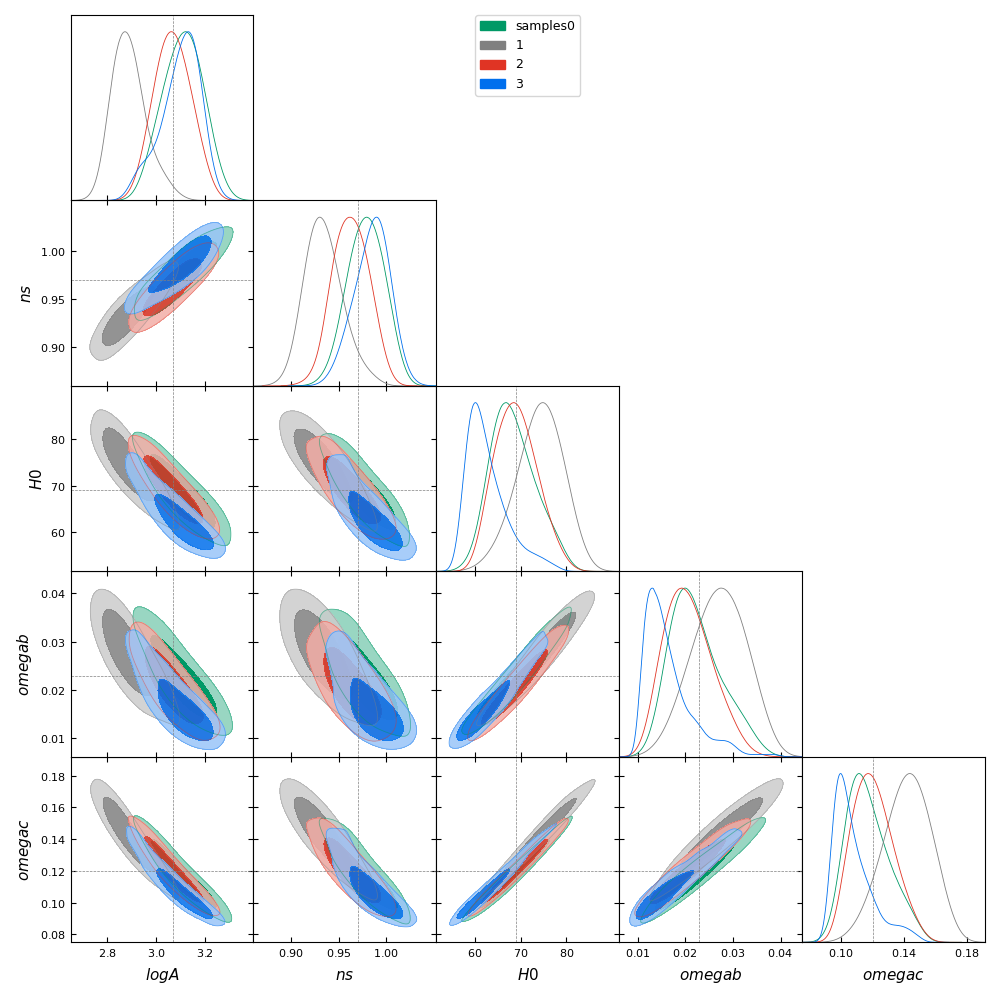

In [16]:
# EMPTY

In [17]:
# EMPTY

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [ ]:
# EMPTY